
# Consumer Complaints Text Classification and Prediction (Multiclass)

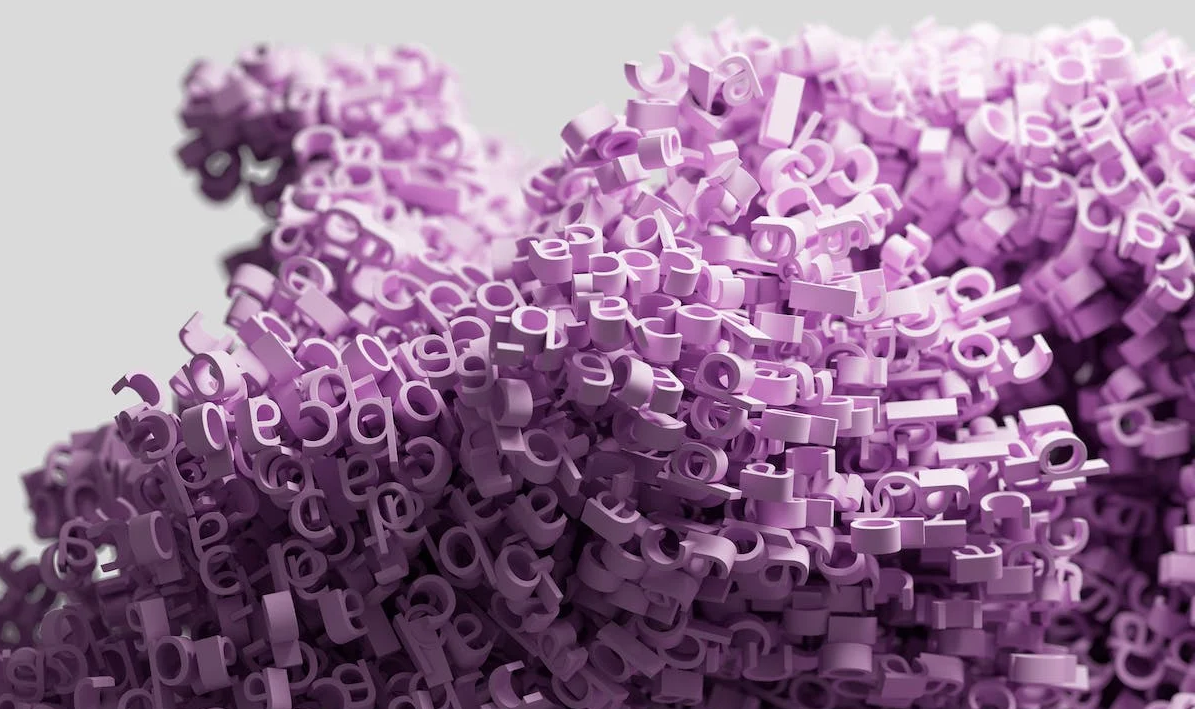

## Disclaimer

-----------------------------------------------------------------------------------------
**This data science notebook is provided for educational purposes only.**

It contains code, analysis, and models that are intended to serve as learning materials and examples. The content is not intended for direct deployment to production environments.

You are encouraged to adapt and modify the contents of this notebook in accordance with the license provided in the associated github repository. However, it is essential to exercise caution, further development, and thorough testing before considering any deployment to production systems.

The authors and contributors of this notebook assume no liability for any consequences, including financial or operational, resulting from the use or misuse of the information and code provided herein. Always consult with appropriate experts and conduct rigorous testing and validation before applying any techniques or models in a real-world, production context.

**By using this notebook, you agree to these terms and conditions.**

-----------------------------------------------------------------------------------------


## Content

Consumer complaints received about financial products and services, these are real world complaints received about financial products and services. Each complaint has been labeled with a specific product; therefore, this is a supervised text classification problem. With the aim to classify future complaints based on its content, we used different machine learning algorithms can make more accurate predictions (i.e., classify the complaint in one of the product categories).

## Resources and acknowledgements

Notebook adapted from this [IBM Cloud example](https://eu-gb.dataplatform.cloud.ibm.com/analytics/notebooks/v2/eb624a2a-edd1-4971-8a66-3c67c6f1d8c9/view?access_token=f81b54fdcf1cfcb574b4a1c29ddfc20f56bc342477a405e59b38587a506d177e)

Public dataset downloaded from the Consumer Financial Protection Bureau (CFBP)'s [public data portal](https://www.consumerfinance.gov/data-research/consumer-complaints/).

## Defining our target

Classify consumer complaints into predefined categories.

Classification algorithms: Linear Support Vector Machine (LinearSVM) and Multinomial Naive Bayes .

Note: Text classification is an example of supervised machine learning since we train the model with labelled data.

## Installing and importing libraries

In [1]:
##########################################
# General helper functions and libraries #
##########################################
from assets.getting_started import connect_to_database
import os
import psycopg2
import pandas as pd
import numpy as np
from scipy.stats import randint
from io import StringIO
import gc

####################
# Modeling process #
####################

# Preprocessing
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfTransformer

# Actual models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Evaluation metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Visualization
from IPython.display import display
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns

## Getting the data

In [2]:
c = connect_to_database()
q1 = """
  SELECT COUNT(*)
  FROM datagymnasium."consumer_complaints";
"""
c.execute(q1)
len_of_df = c.fetchall()[0][0]
q2 = """
  SELECT COUNT(*)
  FROM INFORMATION_SCHEMA.COLUMNS
  WHERE table_schema = 'datagymnasium' AND table_name = 'consumer_complaints'
"""
c.execute(q2)
num_of_columns = c.fetchall()[0][0]
print(f"Shape of dataset: ({len_of_df}, {num_of_columns})")

Shape of dataset: (4150918, 18)


## Cleaning the data
In our complaints dataset, we have over 4.1 million observations (rows), each with 18 featuers (columns)

In [3]:
c = connect_to_database()
q = """
  SELECT *
  FROM datagymnasium."consumer_complaints"
  LIMIT 10
"""
c.execute(q)
cols = [desc[0] for desc in c.description]
df = pd.DataFrame(c.fetchall(), columns=cols)
df.head(2).T

0  \
Date received                                                        2023-07-21   
Product                       Credit reporting  credit repair services  or o...   
Sub-product                                                    Credit reporting   
Issue                                               Improper use of your report   
Sub-issue                     Credit inquiries on your report that you don't...   
Consumer complaint narrative                                               None   
Company public response                                                    None   
Company                                                           EQUIFAX  INC.   
State                                                                        IL   
ZIP code                                                                  60527   
Tags                                                                       None   
Consumer consent provided?                                 Consent not provided   
Submitted via                                                               Web   
Date sent to company                                                 2023-07-21   
Company response to consumer                    Closed with non-monetary relief   
Timely response?                                                            Yes   
Consumer disputed?                                                         None   
Complaint ID                                                            7286535   

                                                                              1  
Date received                                                        2023-09-23  
Product                       Credit reporting or other personal consumer re...  
Sub-product                                                    Credit reporting  
Issue                                      Incorrect information on your report  
Sub-issue                                        Personal information incorrect  
Consumer complaint narrative                                               None  
Company public response                                                    None  
Company                                     Experian Information Solutions Inc.  
State                                                                        TX  
ZIP code                                                                  78258  
Tags                                                                       None  
Consumer consent provided?                                                 None  
Submitted via                                                               Web  
Date sent to company                                                 2023-09-23  
Company response to consumer                                        In progress  
Timely response?                                                            Yes  
Consumer disputed?                                                         None  
Complaint ID                                                            7589845

The dataset contains features that are not necessary to solve our multi-classification problem. For this text classification problem, we are going to build another dataframe that contains `Product` and `Consumer complaint narrative` (which we'll rename to `Complaint`).

In [4]:
c = connect_to_database()
q = """
  SELECT "Product", "Consumer complaint narrative" AS "Complaint"
  FROM datagymnasium."consumer_complaints"
  WHERE "Consumer complaint narrative" IS NOT NULL
"""
c.execute(q)
cols = [desc[0] for desc in c.description]
df1 = pd.DataFrame(c.fetchall(), columns=cols)
df1.shape

(1505895, 2)

In [5]:
total = df1['Complaint'].notnull().sum()
round((total/len_of_df*100),1)

36.3

Of the original 4.1+ million observations, we are left with just under 1.5 million (36.3%) that have an actual complaint body populated.

In [6]:
# Data cleaning
# Note: because we have limited RAM on free tier, we'll want to clean up variables we're no longer using
# In a real-world data science setup, we'd likely want to keep these around in case we need to go back to them for further experimentation
del df
gc.collect()

0

In [7]:
df1.head(15)

Product  \
0   Credit reporting  credit repair services  or o...   
1                                     Debt collection   
2                                            Mortgage   
3   Credit reporting  credit repair services  or o...   
4                                     Debt collection   
5                                     Debt collection   
6   Credit reporting  credit repair services  or o...   
7   Credit reporting  credit repair services  or o...   
8   Credit reporting  credit repair services  or o...   
9   Credit reporting  credit repair services  or o...   
10  Credit reporting  credit repair services  or o...   
11  Credit reporting  credit repair services  or o...   
12  Credit reporting  credit repair services  or o...   
13  Credit reporting  credit repair services  or o...   
14  Credit reporting  credit repair services  or o...   

                                            Complaint  
0   "In XX/XX/2023  I began the process of communi...  
1   I was injured in XXXX i filled long trem XXXX ...  
2   Contacted Wells Fargo the week of XX/XX/2023 s...  
3   In accordance with the Fair Credit Reporting A...  
4   Since 2022 I have attempted to dispute a debt ...  
5   I have been dealing with this XXXX XXXX issue ...  
6   I am urging you to take action on these inaccu...  
7   In accordance with the Fair Credit Reporting a...  
8   I pulled my credit report and noticed unauthor...  
9   XXXX has posted an allege debt of {$230.00} on...  
10  I filed bankruptcy XXXX of XXXX. After it disc...  
11  When I reviewed my credit report  I discovered...  
12  The unverified items indicated below continue ...  
13  When I reviewed my credit report  I discovered...  
14  Months ago  I sent the XXXX credit bureaus a l...

In [8]:
pd.DataFrame(df1.Product.unique()).values

array([['Credit reporting  credit repair services  or other personal consumer reports'],
       ['Debt collection'],
       ['Mortgage'],
       ['Credit card or prepaid card'],
       ['Payday loan  title loan  or personal loan'],
       ['Checking or savings account'],
       ['Student loan'],
       ['Credit reporting or other personal consumer reports'],
       ['Money transfer  virtual currency  or money service'],
       ['Vehicle loan or lease'],
       ['Credit card'],
       ['Prepaid card'],
       ['Payday loan  title loan  personal loan  or advance loan'],
       ['Debt or credit management'],
       ['Consumer Loan'],
       ['Money transfers'],
       ['Credit reporting'],
       ['Payday loan'],
       ['Bank account or service'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

In [9]:
len(df1.Product.unique())

21

There are 21 different classes or categories (i.e., the target our model will predict). However; it is observed that some classes are contained in others. For instance, `Credit card` and `Prepaid card` are contained in `Credit card or prepaid card` category. Now, imagine there is a new complaint about Credit card and we want to classify it. The algorithm can either classify this complaint as `Credit card` or `Credit card or prepaid` and it would be correct. Nevertheless, this would affect model performance. In order to avoid this problem, the names of some categories should be renamed.

In [10]:
# Renaming categories
df2 = df1.replace({
    'Product':
      {
        'Credit reporting': 'Credit reporting, repair, or other',
        'Credit reporting or other personal consumer reports': 'Credit reporting, repair, or other',
        'Credit reporting  credit repair services  or other personal consumer reports': 'Credit reporting, repair, or other',
        'Credit card': 'Credit card or prepaid card',
        'Prepaid card': 'Credit card or prepaid card',
        'Payday loan': 'Payday loan, title loan, personal loan, or advance loan',
        'Payday loan  title loan  or personal loan': 'Payday loan, title loan, personal loan, or advance loan',
        'Payday loan  title loan  personal loan  or advance loan': 'Payday loan, title loan, personal loan, or advance loan',
        'Money transfer  virtual currency  or money service': 'Money transfer, virtual currency, or money service',
        'Money transfers': 'Money transfer, virtual currency, or money service',
        'Virtual currency': 'Money transfer, virtual currency, or money service'
      }
    },
    inplace = False) # if this was a MASSIVE dataset, you may not want to make a copy but rather use df1 and inplace = True

In [11]:
# Note: because we have limited RAM on free tier, we'll want to clean up variables we're no longer using
# In a real-world data science setup, we'd likely want to keep these around in case we need to go back to them for further experimentation
del df1
gc.collect()

0

In [12]:
df2.groupby('Product').count()

Complaint
Product                                                      
Bank account or service                                 14885
Checking or savings account                             77877
Consumer Loan                                            9461
Credit card or prepaid card                            128446
Credit reporting, repair, or other                     828539
Debt collection                                        221110
Debt or credit management                                  16
Money transfer, virtual currency, or money service      35264
Mortgage                                               109017
Other financial service                                   292
Payday loan, title loan, personal loan, or adva...      18884
Student loan                                            36075
Vehicle loan or lease                                   26029

Note there are only 10 complaints of 1.5 MILLION that are classified as `Debt or credit management`, so we will combine them with `Other financial service`.

In [13]:
df2.replace({
    'Product':
      {
        'Debt or credit management': 'Other financial service'
      }
    },
    inplace = True)

In [14]:
len(df2.Product.unique())

12

A few observations:

* The number of classes were reduced from 21 to 12.
* Now we need to represent each class as a number, so as our predictive model can better understand the different categories.



In [15]:
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head(10)

Product  \
0  Credit reporting, repair, or other   
1                     Debt collection   
2                            Mortgage   
3  Credit reporting, repair, or other   
4                     Debt collection   
5                     Debt collection   
6  Credit reporting, repair, or other   
7  Credit reporting, repair, or other   
8  Credit reporting, repair, or other   
9  Credit reporting, repair, or other   

                                           Complaint  category_id  
0  "In XX/XX/2023  I began the process of communi...            0  
1  I was injured in XXXX i filled long trem XXXX ...            1  
2  Contacted Wells Fargo the week of XX/XX/2023 s...            2  
3  In accordance with the Fair Credit Reporting A...            0  
4  Since 2022 I have attempted to dispute a debt ...            1  
5  I have been dealing with this XXXX XXXX issue ...            1  
6  I am urging you to take action on these inaccu...            0  
7  In accordance with the Fair Credit Reporting a...            0  
8  I pulled my credit report and noticed unauthor...            0  
9  XXXX has posted an allege debt of {$230.00} on...            0

The bar chart below shows the number of complaints per category. It can be observed that The bar chart below shows the number of complaints per category. It can be observed that most of customer complaints are due to:

* credit reporting, credit repair, or other credit related issues
* debt collection
* mortgage

Note: in a real life scenario, we may want to take note that the first category represents a significantly higher magnitude than the others, and could be disaggregated (e.g., into credit reporting, credit repair, and other).

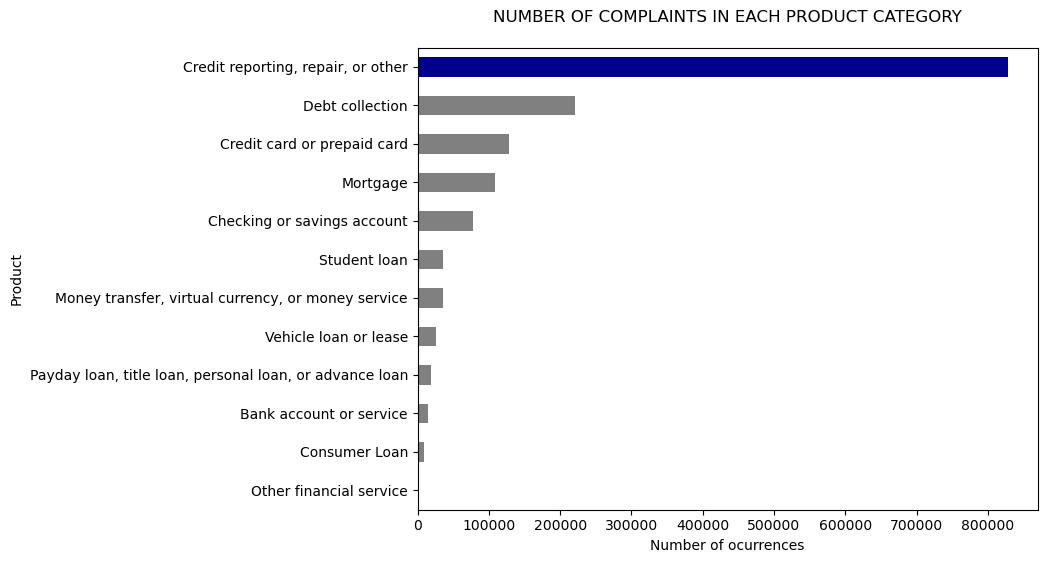

In [16]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10)
plt.show()

## Preprocessing the data

The text needs to be transformed to vectors so as the algorithms will be able make predictions. In this case it will be used the Term Frequency - Inverse Document Frequency (TFIDF) weight to evaluate how important a word is to a document in a collection of documents.

After removing punctuation and lower casing the words, importance of a word is determined in terms of its frequency.




### TF-IDF Primer

Term Frequency – Inverse Document Frequency
TF - IDF is the product of the TF and IDF scores of the term.
TF - IDF = TF / IDF

Term Frequency : This summarizes how often a given word appears within a document.

TF = Number of times the term appears in the docTotal number of words in the doc

Inverse Document Frequency: This downscales words that appear a lot across "documents" (i.e., our complaints observations in this case). A term has a high IDF score if it appears in a few documents. Conversely, if the term is very common among documents (i.e., “the”, “a”, “is”), the term would have a low IDF score.

IDF = ln (Number of docsNumber docs the term appears in)

TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The higher the TFIDF score, the rarer the term is. For instance, in a Mortgage complaint the word mortgage would be mentioned fairly often. However, if we look at other complaints, mortgage probably would not show up in many of them. We can infer that mortgage is most probably an important word in Mortgage complaints as compared to the other products. Therefore, mortgage would have a high TF-IDF score for Mortgage complaints.

`TfidfVectorizer` class can be initialized with the following parameters:

* `min_df`: remove the words from the vocabulary which have occurred in less than `min_df` number of files.
* `max_df`: remove the words from the vocabulary which have occurred in more than _`maxdf` * total number of files in corpus.
* `sublinear_tf`: set to True to scale the term frequency in logarithmic scale.
* `stop_words`: remove the predefined stop words in 'english'.
* `use_idf`: weight factor must use inverse document frequency.
* `ngram_range`: (1, 2) to indicate that unigrams and bigrams will be considered.

So we begin by transforming each complaint into a vector.

In [17]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# WARNING!!! If we use the full dataset of ~1.5 million observations, the following line of code will crash the runtime (RAM resources) on Colab's free tier.
# One option would be to pay for a premium account, and go grab a coffee while this crunches for ~30min
# Because the computation is also time consuming (in terms of CPU), the data was sampled to 15,000 which is sufficient to create a model

df2 = df2.sample(15000, random_state=1337).copy()

features = tfidf.fit_transform(df2.Complaint).toarray() # Note: this will take ~5sec

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 15000 complaints is represented by 36491 features (TF-IDF score of unigrams and bigrams)


Finding the three most correlated terms with each of the product categories

In [18]:
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Bank account or service:
  * Most Correlated Unigrams are: checking, laundering, overdraft
  * Most Correlated Bigrams are: overdraft fees, citi gold, bank charging

==> Checking or savings account:
  * Most Correlated Unigrams are: funds, checking, bank
  * Most Correlated Bigrams are: debit card, savings account, checking account

==> Consumer Loan:
  * Most Correlated Unigrams are: car, disposition, honda
  * Most Correlated Bigrams are: high paying, dealer services, disposition fee

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: citi, rewards, card
  * Most Correlated Bigrams are: new card, american express, credit card

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: 1681, section, reporting
  * Most Correlated Bigrams are: reporting agency, 15 1681, 1681 section

==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: debt collection, collection agency, collect debt

==> M

Pretty cool! We already see that natural language processing has given us some key words that can indicate a category purely off the raw text.

### Splitting the data (train vs test)

Here we will:
1. divide the original data into features (X) and target (y),
2. split into train (75%) and test (25%) sets

Thus, the algorithms will be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [19]:
X = df2['Complaint'] # Collection of "documents" (observations of complaints)
y = df2['Product'] # Target or the labels we want to predict (i.e., the 14 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 1337)

## Training our models


We'll now evaluate two multi-classification models in parallel:

* Linear Support Vector Machine
* Multinomial Naive Bayes



In [20]:
models = [LinearSVC(), MultinomialNB(),]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [21]:
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV) # Note: this line takes around 60 seconds
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


## Testing our models

In [22]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()
acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

Mean Accuracy  Standard deviation
model_name                                      
LinearSVC             0.8276            0.005969
MultinomialNB         0.7066            0.006542

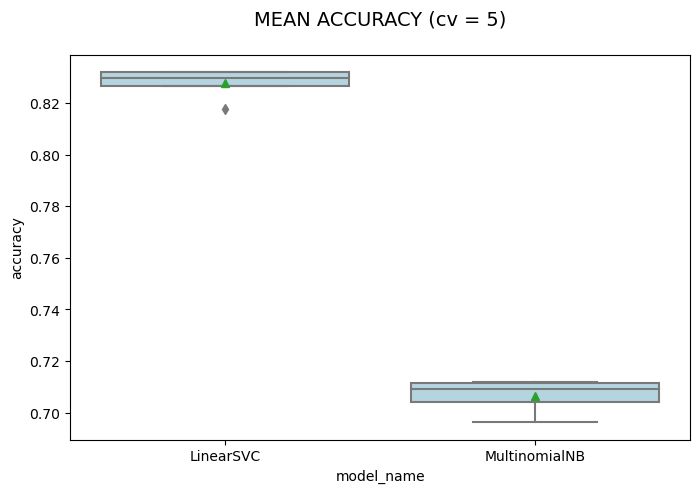

In [23]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14)
plt.show()

## Evaluating our model

In [24]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,
                                                               labels,
                                                               df2.index, test_size=0.25,
                                                               random_state=1336)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Precision, recall, F1 score

In [25]:
# Classification report
print('\t\t\t\tCLASSIFICATION METRICS\n')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df2['Product'].unique()))

				CLASSIFICATION METRICS

                                                         precision    recall  f1-score   support

                     Credit reporting, repair, or other       0.88      0.93      0.91      2098
                            Checking or savings account       0.75      0.72      0.73       525
                                Bank account or service       0.82      0.92      0.87       249
                            Credit card or prepaid card       0.73      0.72      0.72       308
                                        Debt collection       0.68      0.29      0.41        51
     Money transfer, virtual currency, or money service       0.65      0.77      0.70       214
                                               Mortgage       0.84      0.68      0.75        87
                                           Student loan       0.79      0.66      0.72        83
Payday loan, title loan, personal loan, or advance loan       0.64      0.32      0.42        66
 

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We observe that the classes with more support (number of occurrences) tend to have a better f1-score.

This is because the algorithm was trained with more data. In a real-world scenario we could increase our sample size to provide more support for these data points.

The classes that can be classified with most precision are `Credit reporting, repair, or other`, `Vehicle loan or lease`, and `Credit card or prepaid card`, and `Checking or savings account`.


### Confusion Matrix

A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.

If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).


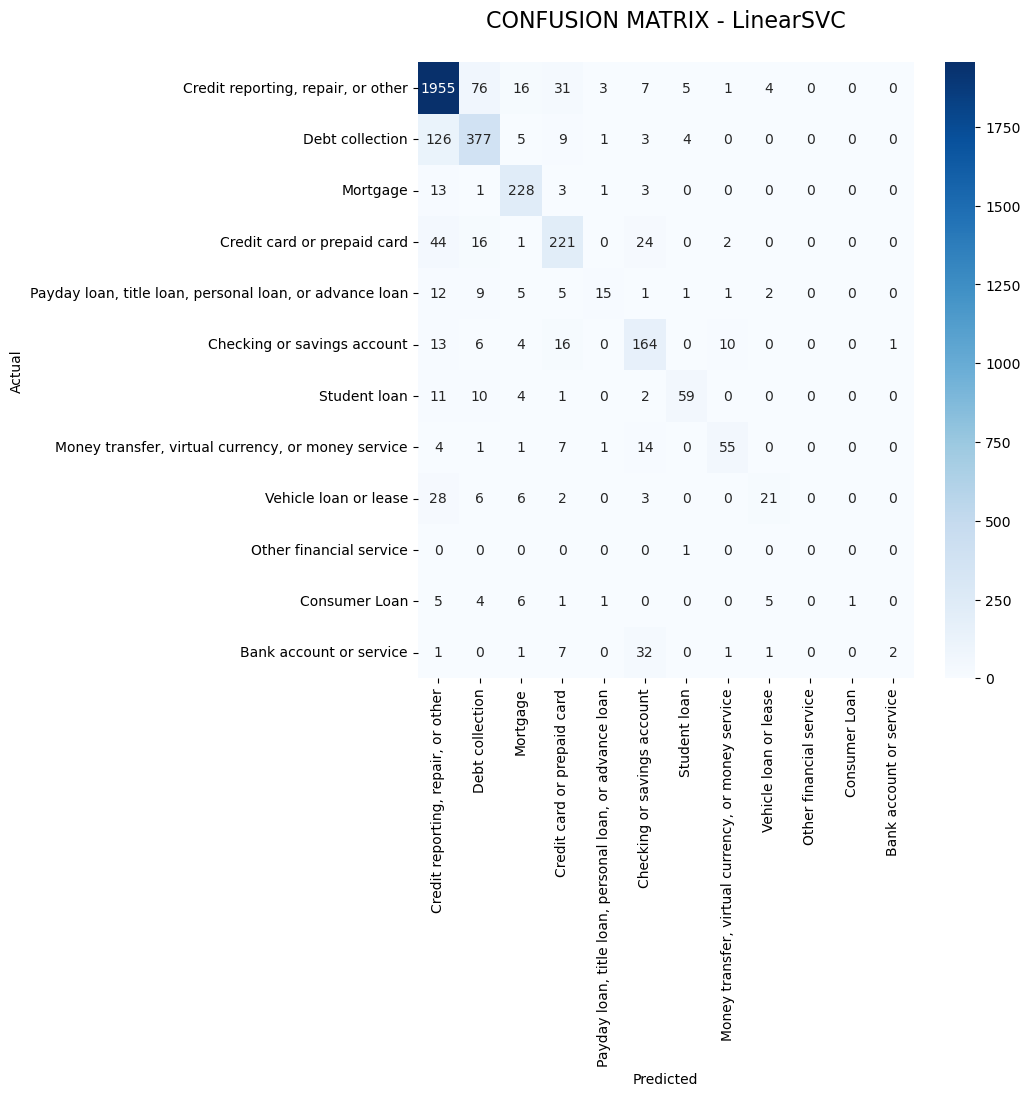

In [26]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values,
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16)
plt.show()

In general, the confusion matrix looks good (clear diagonal that represents correct classifications). Nevertheless, there are cases were the complaint was classified in a wrong class.

### Inspection of misclassifications

Let’s have a look at the cases that were wrongly classified.

In [27]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                                           id_to_category[predicted],
                                                           conf_mat[actual, predicted]))

      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product',
                                                                'Complaint']])
      print('')

'Debt collection' predicted as 'Credit reporting, repair, or other' : 126 examples.


Product                                          Complaint
682141   Debt collection  CRA VIOLATION NO KNOWLEDGE INACCURATE XXXX XXX...
981457   Debt collection  I did n't have a contract with  XXXX  ( origin...
826447   Debt collection  XXXX never contacted me about alleged debt. I ...
220629   Debt collection  This complaint is regarding accounts. Per trac...
1442259  Debt collection  We are receiving a collection from Penn Credit...
...                  ...                                                ...
617418   Debt collection  Debt collection from XXXX XXXX in Florida. Adv...
538712   Debt collection  I am filing this complaint because JPMCB CARD ...
1458133  Debt collection  This company is reporting several items on my ...
16843    Debt collection  I was never advised of the transfer of this de...
1397096  Debt collection  When I got the car it was through a buy here p...

[126 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Credit reporting, repair, or other' : 44 examples.


Product  \
1045078  Credit card or prepaid card   
255281   Credit card or prepaid card   
1152907  Credit card or prepaid card   
1045927  Credit card or prepaid card   
870726   Credit card or prepaid card   
1253500  Credit card or prepaid card   
745746   Credit card or prepaid card   
821829   Credit card or prepaid card   
963994   Credit card or prepaid card   
810823   Credit card or prepaid card   
841350   Credit card or prepaid card   
860846   Credit card or prepaid card   
128868   Credit card or prepaid card   
1157715  Credit card or prepaid card   
1160505  Credit card or prepaid card   
943535   Credit card or prepaid card   
510264   Credit card or prepaid card   
825027   Credit card or prepaid card   
337483   Credit card or prepaid card   
679939   Credit card or prepaid card   
967519   Credit card or prepaid card   
485458   Credit card or prepaid card   
485017   Credit card or prepaid card   
329952   Credit card or prepaid card   
755928   Credit card or prepaid card   
547112   Credit card or prepaid card   
663666   Credit card or prepaid card   
562010   Credit card or prepaid card   
1001592  Credit card or prepaid card   
1338952  Credit card or prepaid card   
876689   Credit card or prepaid card   
1451051  Credit card or prepaid card   
278660   Credit card or prepaid card   
787040   Credit card or prepaid card   
850352   Credit card or prepaid card   
570298   Credit card or prepaid card   
302053   Credit card or prepaid card   
823062   Credit card or prepaid card   
658163   Credit card or prepaid card   
346044   Credit card or prepaid card   
1291705  Credit card or prepaid card   
38805    Credit card or prepaid card   
1220179  Credit card or prepaid card   
1319512  Credit card or prepaid card   

                                                 Complaint  
1045078  I went to Walmart as I always do to get my wee...  
255281   To whom this may concern my Tracking for my ch...  
1152907  I have an excellent credit history  I am a hom...  
1045927   Overlimit fee paid without my consent or opt in.  
870726   I am a victim of identity theft. Due to the Co...  
1253500  It is my understanding as of XXXX My issue reg...  
745746   XX/XX/2018 Several Tire Orders were Cancelled....  
821829   My mother XXXX XXXX made me an authorized user...  
963994   Somebody used my information  name and social ...  
810823   Chase Bank refused to refund {$1300.00} for a ...  
841350   "This is my second CFBP compliant. I am asking...  
860846   Wells Fargo you are in violation of the FDCPA ...  
128868   Reference : Loan number XXXX XXXX XXXX XXXX XX...  
1157715  Chase Bank sold my account to a collection age...  
1160505  "I applied for a XXXX Credit card through Sync...  
943535   I was stunned after I obtained my XXXX  XXXX a...  
510264   I XXXX XXXX ; XXXX am writing you as an aggrie...  
825027   I just took a look at my credit and noticed th...  
337483   My credit application was denied in violation ...  
679939   I have two typical credit cards from Capital O...  
967519   "I am writing to express my dissatisfaction re...  
485458   "I submitted dispute of {$1.00} on XXXX for th...  
485017   Unable to add authorized user. Added an author...  
329952   I was shocked when I reviewed my credit report...  
755928   Thursday  XX/XX/XXXX at XXXX PM Receive two te...  
547112   "On my XXXX statement the balance subject to i...  
663666   I believe that I am a victim of fraud and/or i...  
562010   I have this police report where I stated that ...  
1001592  I went to see a financi al counselor   i  n  X...  
1338952  Synchrony Financial closed my account on XX/XX...  
876689   Capital one put 3 adverse accounts on all 3 of...  
1451051  This complaint is more information for the one...  
278660   In 2018 I was granted XXXX  in the United Stat...  
787040   I never been late with this accounts  and plea...  
850352   On XX/XX/2020 my bill did not go through when ...  
570298   My account should not s


'Vehicle loan or lease' predicted as 'Credit reporting, repair, or other' : 28 examples.


Product  \
1172449  Vehicle loan or lease   
719155   Vehicle loan or lease   
429412   Vehicle loan or lease   
1217213  Vehicle loan or lease   
4733     Vehicle loan or lease   
523493   Vehicle loan or lease   
332367   Vehicle loan or lease   
1021798  Vehicle loan or lease   
646729   Vehicle loan or lease   
730993   Vehicle loan or lease   
662915   Vehicle loan or lease   
679818   Vehicle loan or lease   
403557   Vehicle loan or lease   
82440    Vehicle loan or lease   
986989   Vehicle loan or lease   
567291   Vehicle loan or lease   
923777   Vehicle loan or lease   
95748    Vehicle loan or lease   
497359   Vehicle loan or lease   
1263242  Vehicle loan or lease   
1342160  Vehicle loan or lease   
696509   Vehicle loan or lease   
878781   Vehicle loan or lease   
1331849  Vehicle loan or lease   
1461416  Vehicle loan or lease   
1068631  Vehicle loan or lease   
46773    Vehicle loan or lease   
1220544  Vehicle loan or lease   

                                                 Complaint  
1172449  Several Payments are being reported as late on...  
719155   XXXX XXXX is reporting a repossession on my cr...  
429412   I called several times requesting a copy of my...  
1217213  I called Ally Auto around XX/XX/XXXX and spoke...  
4733     I have paid over {$30000.00} towards this car ...  
523493   Community Bank has discriminated against mysel...  
332367   THIS IS NOT A DUPLICATE!!!!  THIS IS A RESPONS...  
1021798  I recently looked at my credit reports and not...  
646729   On XX/XX/2020 a car loan was realesed in my na...  
730993   I have been banking with Navy Federal Credit U...  
662915   "I had a XXXX XXXX XXXX that was returned to K...  
679818   I am a victim of identity theft. I have report...  
403557   On XXXX XXXX the car dealership asked for a do...  
82440    Back in XXXX or around XXXX Capital One Financ...  
986989   I am being discriminated for my age  race and/...  
567291   In accordance with the fair credit Reporting a...  
923777   I had pushed a loan payment back to the end of...  
95748    I have been disputing credit acceptance since ...  
497359   On XX/XX/XXXX I purchased a new XXXX XXXX XXXX...  
1263242  I was a victim of a predatory auto loan- they ...  
1342160  Car was paid off on XXXX and I havent received...  
696509   "I purchased a used Truck through XXXX XXXX XX...  
878781   "I purchased a XXXX  XXXX from Clay Cooley XXX...  
1331849  "1. PRESTIGE FINANCIAL SVC Account XXXX**** Pl...  
1461416  In accordance with the fair credit Reporting a...  
1068631  "i leased an automobile from kia of XXXX in oh...  
46773    I am a Service member and I fall under the Ser...  
1220544  DT CREDIT Address po box XXXX XXXX  AZ XXXX Ph...


'Credit reporting, repair, or other' predicted as 'Debt collection' : 76 examples.


Product  \
952808   Credit reporting, repair, or other   
1354218  Credit reporting, repair, or other   
2086     Credit reporting, repair, or other   
696771   Credit reporting, repair, or other   
957601   Credit reporting, repair, or other   
...                                     ...   
1230171  Credit reporting, repair, or other   
949172   Credit reporting, repair, or other   
601113   Credit reporting, repair, or other   
531737   Credit reporting, repair, or other   
759708   Credit reporting, repair, or other   

                                                 Complaint  
952808   My wife and I were victims of fraud committed ...  
1354218  XXXX Account Number XXXX collection department...  
2086     NCB management has sent me a letter stating my...  
696771   Portfolio Recovery Associates  LLC is in viola...  
957601   Bank of America reports multiple account numbe...  
...                                                    ...  
1230171  Please See Attached I am writing on this lette...  
949172   I  XXXX XXXX  have written this letter to disp...  
601113   Between XX/XX/2018 and XX/XX/2018  your RECEIV...  
531737   In XXXX we had to have two cars repossessed vo...  
759708   A collection account for {$1300.00} appeared o...  

[76 rows x 2 columns]


'Credit reporting, repair, or other' predicted as 'Credit card or prepaid card' : 31 examples.


Product  \
864391   Credit reporting, repair, or other   
996105   Credit reporting, repair, or other   
99008    Credit reporting, repair, or other   
739122   Credit reporting, repair, or other   
925489   Credit reporting, repair, or other   
1428711  Credit reporting, repair, or other   
621507   Credit reporting, repair, or other   
1259440  Credit reporting, repair, or other   
269009   Credit reporting, repair, or other   
598609   Credit reporting, repair, or other   
1448165  Credit reporting, repair, or other   
509917   Credit reporting, repair, or other   
274644   Credit reporting, repair, or other   
296514   Credit reporting, repair, or other   
119181   Credit reporting, repair, or other   
500485   Credit reporting, repair, or other   
1130716  Credit reporting, repair, or other   
570092   Credit reporting, repair, or other   
683036   Credit reporting, repair, or other   
1079863  Credit reporting, repair, or other   
674524   Credit reporting, repair, or other   
426514   Credit reporting, repair, or other   
814450   Credit reporting, repair, or other   
108184   Credit reporting, repair, or other   
165135   Credit reporting, repair, or other   
806026   Credit reporting, repair, or other   
896984   Credit reporting, repair, or other   
212256   Credit reporting, repair, or other   
688013   Credit reporting, repair, or other   
1306185  Credit reporting, repair, or other   
600869   Credit reporting, repair, or other   

                                                 Complaint  
864391   Hello I reached out to this merchant regarding...  
996105   From : XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX...  
99008    XXXX XXXX XXXX was bought out by XXXX XXXX XXX...  
739122   I've always had a credit score of over 800 bec...  
925489   A {$28.00} dollar part was supposedly shipped ...  
1428711  This is a complaint against XXXX XXXX XXXX  th...  
621507   In XX/XX/XXXX  I had lost my credit card ( cap...  
1259440  I had citi credit cards means citi bank  it wa...  
269009   My XXXX  is stating I have an open account for...  
598609   My XXXX XXXX XXXX  MasterCard credit card acco...  
1448165  In XXXX of 2017 I got sick. I totally spaced o...  
509917   I have a banana republic credit card where I i...  
274644   "On XX/XX/XXXX  I went to a time share present...  
296514   Today  XX/XX/XXXX  I received a report that a ...  
119181   To Whom It May Concern : I have authenticated ...  
500485   on date .XXXX ... some call tell my that if i ...  
1130716  I have disputed a {$230.00} cc charge XXXXAT o...  
570092   XX/XX/2018  Inquiry Date Inquire Name Chase Ca...  
683036   I currently hold a credit account with Capital...  
1079863  I have contacted each credit company at least ...  
674524   The Bank Of America Credit card shows open and...  
426514   In XXXX of XXXX i noticed transactions being c...  
814450   In XXXX I called Acima and told them I had bee...  
108184   My dispute involves a missed payment reported ...  
165135   I have XXXX  CREDIT CARD ENDING XXXX since XXX...  
806026   "My trouble is with my XXXX credit card which ...  
896984   Got frauded in XX/XX/2018 They caught the frau...  
212256   My card and phone had got stolen and the bill ...  
688013   I had interest charged to my account after I p...  
1306185  I applied for and was approved for a XXXX XXXX...  
600869   i have a XXXX XXXX rewards card on XX/XX/XXXX ...


'Credit card or prepaid card' predicted as 'Checking or savings account' : 24 examples.


Product  \
813464   Credit card or prepaid card   
1465823  Credit card or prepaid card   
481468   Credit card or prepaid card   
255607   Credit card or prepaid card   
806680   Credit card or prepaid card   
1376631  Credit card or prepaid card   
1226078  Credit card or prepaid card   
1186495  Credit card or prepaid card   
644090   Credit card or prepaid card   
420819   Credit card or prepaid card   
890248   Credit card or prepaid card   
320786   Credit card or prepaid card   
622996   Credit card or prepaid card   
685094   Credit card or prepaid card   
706974   Credit card or prepaid card   
881954   Credit card or prepaid card   
1432761  Credit card or prepaid card   
1050500  Credit card or prepaid card   
735827   Credit card or prepaid card   
1099779  Credit card or prepaid card   
1237460  Credit card or prepaid card   
1259538  Credit card or prepaid card   
210792   Credit card or prepaid card   
764065   Credit card or prepaid card   

                                                 Complaint  
813464   "This complaint is about my principle bank   P...  
1465823  On Monday  XX/XX/2022  I spent over an hour re...  
481468   XX/XX/XXXX I reported ( 2 ) XXXX XX/XX/XXXX tr...  
255607   "On XX/XX/2022  my personal checking account a...  
806680   I noticed a transaction on my XXXX account tha...  
1376631  I received this creditcard ending in at my req...  
1226078  Chase Bank sent me an invitation for a credit ...  
1186495  1. ) In XX/XX/XXXX in violation of fair credit...  
644090   concerning complaint # XXXX filed with the CFP...  
420819   On XX/XX/XXXX our CitiCard was charged {$3300....  
890248   On the XXXX of XXXX b of a charge me and took ...  
320786   I have a Bluebird by AMEX account I use for my...  
622996   On XX/XX/XXXX American Express Bluebird was do...  
685094   May credit card was closed on XX/XX/2017 by We...  
706974   On XX/XX/XXXX of XXXX I purchased 2 tickets fr...  
881954   i had some lost my wallet with everything in i...  
1432761  while I was checking the balance and transacti...  
1050500  My elderly father opened a checking account wi...  
735827   On Saturday XX/XX/2019 I made an online paymen...  
1099779  On XXXX/XXXX/XXXX at XXXX XXXX Contacted AMEX ...  
1237460  This complaint is directed against TRUIST Bank...  
1259538  Hello  I received a letter in the mail from Ch...  
210792   On XX/XX/23 got charged with XXXX x XXXX for g...  
764065   PNC has withheld funds now for 2 1/2 years. Th...


'Bank account or service' predicted as 'Checking or savings account' : 32 examples.


Product  \
1025471  Bank account or service   
1028686  Bank account or service   
1375703  Bank account or service   
1071606  Bank account or service   
1145313  Bank account or service   
1051703  Bank account or service   
1140059  Bank account or service   
1362404  Bank account or service   
1368607  Bank account or service   
1058051  Bank account or service   
1097073  Bank account or service   
1140628  Bank account or service   
1051518  Bank account or service   
1010574  Bank account or service   
1147034  Bank account or service   
1062682  Bank account or service   
636493   Bank account or service   
1114212  Bank account or service   
1062824  Bank account or service   
1155386  Bank account or service   
1099241  Bank account or service   
1364726  Bank account or service   
1366889  Bank account or service   
1076033  Bank account or service   
107097   Bank account or service   
1066236  Bank account or service   
1366019  Bank account or service   
74029    Bank account or service   
1016453  Bank account or service   
1123882  Bank account or service   
1010547  Bank account or service   
1147276  Bank account or service   

                                                 Complaint  
1025471  I opened an account with Citi Bank ( represent...  
1028686  Associated Bank knowingly misled me  I tried t...  
1375703  I had overdraft protection with Regions Bank i...  
1071606  I received a letter to my physical address I p...  
1145313  "My aunt is XXXX years old and has been bankin...  
1051703  My husband and I boh have an account with Well...  
1140059  "THIS IS NOT A DUPLICATE : XXXX accounts were ...  
1362404  I have been a customer of Bank of America for ...  
1368607  We opened an account through GE Capitol i.e sy...  
1058051  "Wells Fargo Bank in NC  where I bought and so...  
1097073  Funds were transferred from XXXX account to Ca...  
1140628  I was married and in a abusive relationship. O...  
1051518  "I recently ( on XX/XX/XXXX ) opened a new che...  
1010574  On XX/XX/2017  I did my banking at the XXXX Hu...  
1147034  Chase closed my newly opened account with no e...  
1062682  I live in XXXX  NY and I use Wells Fargo bank....  
636493   my money went to an account at the navy federa...  
1114212  "Last year the weekend of XXXX XXXX  2015 ther...  
1062824  We had a negative account balance for over six...  
1155386  On XXXX/XXXX/16 I visited a J.P. Morgan Chase ...  
1099241  "This is an addendum to my initial complaint a...  
1364726  I had XXXX checkings and XXXX saving account w...  
1366889  Chase bank breached my account  and gave my in...  
1076033  Discover bank is not honoring it 's promotiona...  
107097   My account was closed with no warning or commu...  
1066236  I open an account at Wells Fargo in XXXX 2014....  
1366019  Information withheld from me. Unauthorized acc...  
74029    I deposited XXXX money orders on XX/XX/XXXX an...  
1016453  On XXXX XXXX  XXXX  I went to the XXXX XXXX XX...  
1123882  I went into the lobby of the Bank of America i...  
1010547  When I reviewed my bank of America SAVINGS acc...  
1147276  I 'm getting hammered with OD fees on my busin...

### Most correlated terms with each category

In [28]:
N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Bank account or service':
  * Top unigrams: approached, bank, laundering, unfair
  * Top bigrams: stop payment, account navy, bank charging, account month

==> 'Checking or savings account':
  * Top unigrams: bank, check, checking, funds
  * Top bigrams: debit card, fee account, draft fees, called bank

==> 'Consumer Loan':
  * Top unigrams: paying, honda, period, feel
  * Top bigrams: xxxx car, car told, derogatory account, loan paid

==> 'Credit card or prepaid card':
  * Top unigrams: card, rewards, capital, charges
  * Top bigrams: american express, balance transfer, report permission, use card

==> 'Credit reporting, repair, or other':
  * Top unigrams: equifax, experian, transunion, report
  * Top bigrams: xxxx xxxx, xxxx reporting, xxxx balance, responsible debt

==> 'Debt collection':
  * Top unigrams: debt, owe, collection, collect
  * Top bigrams: paid credit, xxxx contract, credit wrong, items belong

==> 'Money transfer, virtual currency, or money service':
  * Top un

### Predictions

Now let's make predictions against unseen data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [30]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


The algorithm has classified this text as a "Student loan" complaint. Makes sense!

Now let's check another complaint.

In [31]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair, or other']


## Preparing for next steps

It appears our model is doing well for just an hour's worth of work!

Of course, there are many nuances that must be accounted for in real-world scenarios, including:

* Multilingual complaints (this set is only english)
* Messy or inconsistent labeling (this set is already cleaned by CFPB before publishing)
* Completely missing labels (in an authority where consumer complaints are not yet digital, labeled datasets needed to train the model can break)